<a href="https://colab.research.google.com/github/ProffNdhlovu/Proff/blob/master/Copy_of_mane4140_mane6140_1D_periodic_ADeqn_explicit_implicit_ex1_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

alpha: 0.625
beta: 0.0125


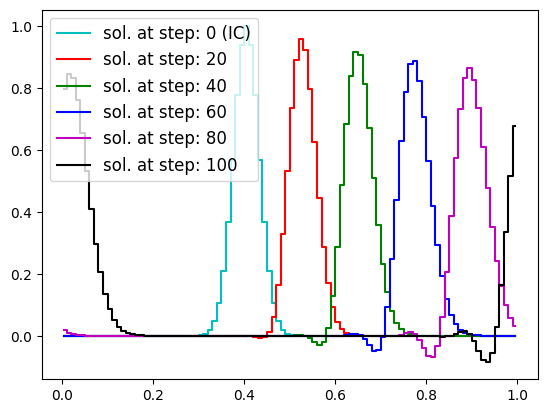

In [10]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

def get_xmin():
    # return left end of domain
    xmin = 0.0
    return xmin

def get_xmax():
    # return right end of domain
    xmax = 1.0
    return xmax

def get_L():
    # return length of domain
    L = get_xmax()-get_xmin()
    return L

def get_ax():
    # return advection velocity value
    ax = 0.1
    return ax

def get_kappa():
    # return kappa value
    kappa = 1e-5
    assert(kappa>=0)
    return kappa

def get_N():
    # return number of elements in the mesh
    N = 100
    return N

def get_deltax():
    # return mesh size
    deltax = get_L()/get_N() # uniform mesh
    return deltax

def get_Nt():
    # return number of time intervals
    # note 'Nt' is number of time intervals and 'Nt+1' is number of time steps
    Nt = 100
    return Nt

def get_deltat():
    # return time-step size
    L = get_L()
    ax = get_ax()
    kappa = get_kappa()
    deltat = 0.0
    T = L/ax # time to travel entire domain
    deltat = 0.625*T/get_Nt() # Nt intervals cover 0.625x the time to travel entire domain
    return deltat

def get_IC_Gaussian(xcells):
    # return Gaussian initial condition
    N = get_N()
    assert(xcells.shape[0]==N)

    xmin = get_xmin()
    xmax = get_xmax()
    L = get_L()
    phi_center = xmin+get_deltax()*(np.floor(0.4*N)+0.5) # coincides on a cell center at ~40% domain
    phi_spread = 4.0*max(get_deltax(),L/100) # at least equal to width of 4 cells

    assert((phi_center-xmin)/phi_spread>=4 and (xmax-phi_center)/phi_spread>=4) # avoid interference with left and right ends

    phi0 = np.zeros(N) # index in [0,N-1]
    for j in range(0,N): # loop index in [0,N-1]
        phi0[j] = 1.0*np.exp(-(xcells[j]-phi_center)**2/phi_spread**2)

    return phi0

def apply_num_scheme():
    # apply numerical scheme

    xmin = get_xmin()
    xmax = get_xmax()
    L = xmax-xmin
    ax = get_ax()
    kappa = get_kappa()

    N = get_N()
    deltax = get_deltax()
    Nt = get_Nt()
    deltat = get_deltat()

    display_phi_plot = True
    nplots = 5 # number of steps to plot solution (excluding IC/n=0 step)
    nplots_marker = ['r','g','b','m','k']
    assert(nplots<=len(nplots_marker))
    debug_flag = True

    assert(ax>=0) # advection is positive from left to right
    alpha = ax*deltat/deltax
    if (debug_flag):
        print('alpha:',alpha)
    beta = 2*kappa*deltat/deltax**2
    if (debug_flag):
        print('beta:',beta)

    xcells = np.linspace(xmin+deltax/2.0,xmax-deltax/2.0,N,endpoint=True) # mesh cell locations

    phi_curr = get_IC_Gaussian(xcells) # \phiav^n \forall j ('curr' for current/known)
    phi_next = np.zeros_like(phi_curr) # \phiav^{n+1} \forall j

    if (display_phi_plot):
        plt.plot(xcells,phi_curr,'c',drawstyle='steps-mid',label='sol. at step: 0 (IC)')

    # use Sherman-Morrison formula (for a 'cyclic' symmetric matrix): A = (A_tri + vxv)
    Abanded = np.zeros([3,N]) # tridiagonal matrix without extra entires due to periodic BC
    v = np.zeros(N) # for extra entires in the left-hand-side/matrix due to periodic BC
    b = np.zeros(N) # right-hand-side vector
    # note Abanded is constant in space/time (for uniform cells and time steps, and constant kappa)
    # loop over mesh cells
    for j in range(N): # loop index in [0,N-1]
        # recall Abanded[u + i - j, j] == A[i,j] with u=1 and l=1 for a tridiagonal matrix
        Abanded[0,j] = -beta/4
        Abanded[1,j] = 1+(beta/2)
        Abanded[2,j] = -beta/4

    v[0] = 0.5 # this is arbitrary/non-unique but make sure Abanded doesn't become singular
    v[N-1] = (-beta/2)/v[0]

    Abanded[1,0] = Abanded[1,0] - v[0]**2
    Abanded[1,N-1] = Abanded[1,N-1] - v[N-1]**2

    # loop over time steps
    for n in range(1,Nt+1): # loop index in [1,Nt] to start at n=1 (with n=0 as IC) and end at n=Nt (note we have 'Nt+1' steps and 'Nt' intervals in time)

        # use periodic BC
        # explicit upwind scheme for advection and implicit CD scheme for diffusion
        # Note that j=0 is the leftmost cell and j=N-1 is the rightmost cell
        b[0]= ((alpha/2)+((alpha**2)/2)+(beta/4))*phi_curr[N-1]+(1-(alpha**2)-(beta/2))*phi_curr[0]+((-alpha/2)+((alpha**2)/2)+(beta/4))*phi_curr[1]
        b[N-1] = ( (alpha/2)+((alpha**2)/2)+(beta/4))*phi_curr[N-2]+(1-(alpha**2)-(beta/2))*phi_curr[N-1]+((-alpha/2)+((alpha**2)/2)+(beta/4))*phi_curr[0]

        # loop over mesh cells / Changed N to N-1
        for j in range(1,N-1): # loop index in [1,N-1] excluding the leftmost cell
            # explicit upwind scheme for advection and implicit CD scheme for diffusion
            b[j] = ((alpha/2)+((alpha**2)/2)+(beta/4))*phi_curr[j-1]+(1-(alpha**2) - (beta/2))*phi_curr[j]+((-alpha/2)+((alpha**2)/2)+(beta/4))*phi_curr[j+1]

        # use Sherman-Morrison formula (for a 'cyclic' symmetric matrix)
        z1 = solve_banded((1,1),Abanded,b)
        z2 = solve_banded((1,1),Abanded,v)
        phi_next = z1 - ((np.dot(v,z1))/(1+np.dot(v,z2)))*z2

        # set solution computed at 'n+1' to be solution at 'n' for next time step
        phi_curr = copy.deepcopy(phi_next) # 'new' solution becomes 'current' for next step
        if (n%(Nt/nplots)==0):
            plt.plot(xcells,phi_curr,nplots_marker[np.floor(n/(Nt/nplots)-1).astype(int)],drawstyle='steps-mid',label='sol. at step: '+str(n))

    if (display_phi_plot):
        plt.legend(fontsize=12,loc='upper left')
        plt.savefig('mane4140_mane6140_1D_periodic_ADeqn_explicit_implicit_ex1_v1_plot1.pdf')
        plt.show()

apply_num_scheme()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')